In [1]:
import json
import glob
eqs = []
files = glob.glob('pipeline_out/*.jsonlist') 
for f in files:
    with open(f) as processed:
        for i, line in enumerate(processed):
            eqs.append(json.loads(line)['aligned'])
            eq

In [2]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity

In [4]:
eqs

[]

In [4]:
docs = [doc for sublist in eqs for doc in sublist]
dct = Dictionary(docs)
corpus = [dct.doc2bow(line) for line in docs]
model = TfidfModel(corpus)

In [5]:
index = MatrixSimilarity(model[corpus], num_features=len(dct))

In [6]:
line = docs[2]
sims = index[model[dct.doc2bow(line)]]
sims = sorted(enumerate(sims), key=lambda item: -item[1])

In [7]:
from gensim import interfaces, utils, matutils
import numpy as np
# query = matutils.sparse2full(query, self.num_features)
# query = numpy.asarray(query, dtype=self.index.dtype)

# do a little transposition dance to stop numpy from making a copy of
# self.index internally in numpy.dot (very slow).
# result = numpy.dot(self.index, query.T).T  

In [8]:
num_features = len(dct)
all_dists = []
for aligned_eqs in eqs:
    vecs = []
    for e in aligned_eqs: 
        sparse_vec = model[dct.doc2bow(e)]
        query = matutils.sparse2full(sparse_vec, num_features)
        query = np.asarray(query, dtype=np.float32)
        vecs.append(query)
    
    dists = []
    for i, v in enumerate(vecs):
        for j, v2 in enumerate(vecs):
            if i != j:
                dists.append(v.dot(v2))
    all_dists.extend(list(set(dists)))


In [9]:
# now do a random pass
N = len(eqs)
num_features = len(dct)
rand_dists = []
for aligned_eqs in eqs:
    vecs = []
    for e in aligned_eqs: 
        sparse_vec = model[dct.doc2bow(e)]
        query = matutils.sparse2full(sparse_vec, num_features)
        query = np.asarray(query, dtype=np.float32)
        vecs.append(query)
    
    dists = []
    for i, v in enumerate(vecs):
        # pick a random vector
        rand_i = np.random.randint(N)
        # Note: had to pull in a long range dependency on the docs list here. Could cause problems later.
        sparse_vec = model[dct.doc2bow(docs[rand_i])]
        rand_vec = matutils.sparse2full(sparse_vec, num_features)
        rand_vec = np.asarray(rand_vec, dtype=np.float32)
        dists.append(v.dot(rand_vec))
    rand_dists.extend(list(set(dists)))



In [10]:
len(rand_dists)

6942

In [11]:
len(all_dists)

4286

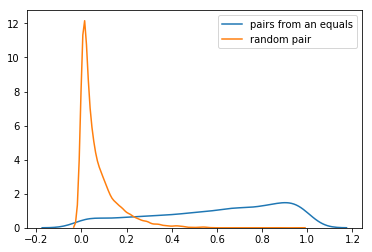

In [12]:
%matplotlib inline
import pandas as pd
import seaborn as sns

# test = pd.DataFrame([all_dists, rand_dists])

sns.distplot(all_dists, hist=False, rug=False, label='pairs from an equals')
sns.distplot(rand_dists, hist=False, rug=False, label = 'random pair')


In [13]:
from modules.ibm_eqs.vocab import Vocab
from modules.ibm_eqs.tr_embed import TREmbed

# eqs = []
#     filename = sys.argv[1]
#     with open(filename, 'r') as infile:
#         for i, line in enumerate(infile):
#             try:
#                 line = json.loads(line)         
#             except:
#                 continue
#             line_len = len(line['clean_split_filtered_tokenized'])
#             if line_len == 2:
#                 eqs.append((line['clean_split_filtered_tokenized'][0], line['clean_split_filtered_tokenized'][1]))
#             if i == 1000000:
#                 break 
# print("read all lines")
# print("{num} equations detected".format(num=len(eqs)))
eqs_matt = [eq for eq in eqs if len(eq) == 2]
v_f = Vocab(eqs_matt)
print("constructing")
eqs_matt_reverse = [(eq[1], eq[0]) for eq in eqs_matt]
v_e = Vocab(eqs_matt_reverse)



constructing


In [14]:
tre = TREmbed(v_f, v_f.transform(eqs_matt))
tre.estimate()
embeds_matt_f = tre.construct_embeds([f for e, f in eqs_matt], k=20)


starting log likelihood: -290859.66224389424
current log likelihood (end of loop): -37361.34981873577
time taken for loop 0: 0.4615229999999997
current log likelihood (end of loop): -15243.1402122165
time taken for loop 1: 0.1306270000000005
current log likelihood (end of loop): -3495.8412437051975
time taken for loop 2: 0.10021300000000011
current log likelihood (end of loop): 1465.1668826925475
time taken for loop 3: 0.12876900000000013
current log likelihood (end of loop): 3898.844686489572
time taken for loop 4: 0.10730099999999965
current log likelihood (end of loop): 5329.666074435934
time taken for loop 5: 0.11099499999999907
current log likelihood (end of loop): 6273.060460763421
time taken for loop 6: 0.10486699999999871
0
1000
2000
embeds constructed, projecting


In [15]:
embeds_matt_e = tre.construct_embeds([e for e, f in eqs_matt], k=20)



0
1000
2000
embeds constructed, projecting


In [16]:
prod = embeds_matt_f @ embeds_matt_e.T

In [17]:
f_mag = np.sqrt(np.sum(np.square(embeds_matt_f), axis = 1))
e_mag = np.sqrt(np.sum(np.square(embeds_matt_e), axis = 1))

In [18]:
prod[0]
cos = np.diag(prod) / f_mag * e_mag
rand_idc = np.random.random_integers(0, prod.shape[0] - 1, prod.shape[0] - 1).shape
rand_cos = prod[rand_idc,:] / f_mag * e_mag
cos[0]

/Users/sam/miniconda3/envs/data_cleaning/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 2896 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


-0.021876076560845868

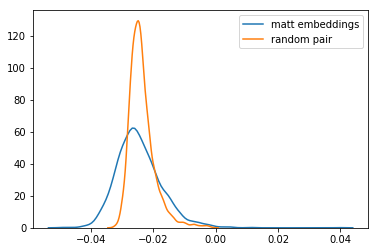

In [19]:
sns.distplot(np.diag(prod), hist=False, rug=False, label = 'matt embeddings')
sns.distplot(prod[rand_idc,:], hist=False, rug=False, label = 'random pair')

In [20]:
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_jobs=2)
Y = tsne.fit_transform(embeds_matt_e)

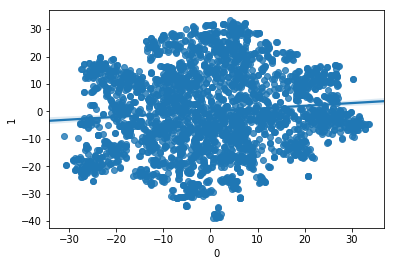

In [25]:
se = pd.DataFrame(Y)
se.columns = ['0', '1']
se['label'] = [e for e, f in eqs_matt]
sns.regplot("0", "1", data=se)


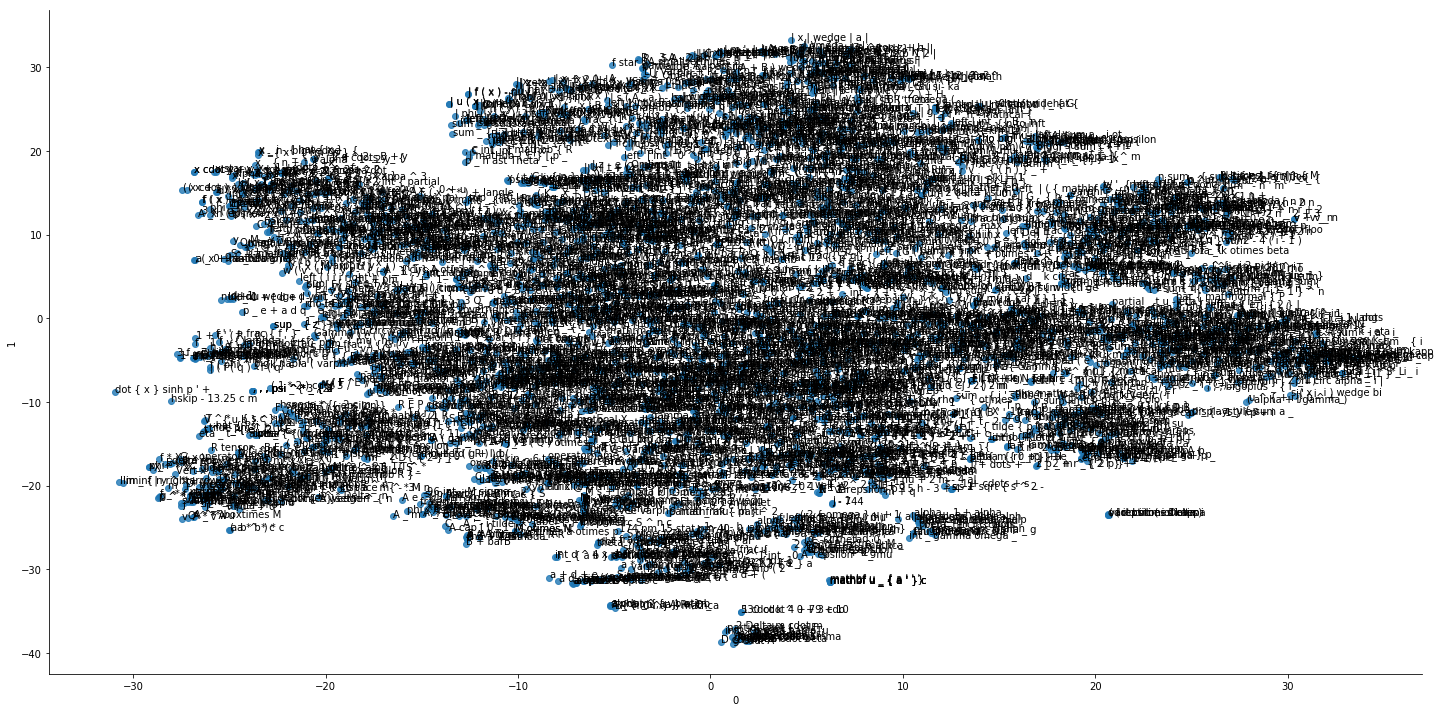

In [28]:
import matplotlib.pyplot as plt
ax = sns.lmplot('0', # Horizontal axis
           '1', # Vertical axis
           data=se, # Data source
           fit_reg=False, # Don't fix a regression line
           size = 10,
           aspect =2 ) # size and dimension

# plt.title('Example Plot')
# Set x-axis label
# plt.xlabel('Sepal Length')
# Set y-axis label
# plt.ylabel('Sepal Width')


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

se['label_clean'] = se['label'].apply(lambda x: " ".join(x).replace('\\', '').replace('$', '')[0:20])
label_point(se['0'], se['1'], se['label_clean'], plt.gca()) 